# Loihi LIF Example

This demonstrates the model parameters for the first tutorial to mimic the first two examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LoihiLIF:
    
    def __init__(self, bias_mant, bias_exp, v_thresh, voltage_tau=0, current_tau=0, spike_weight=6400):
        # save input parameters
        self.bias_mant = bias_mant
        self.bias_exp = bias_exp
        self.v_thresh = v_thresh
        self.voltage_tau = voltage_tau
        self.current_tau = current_tau
        self.spike_weight = spike_weight
        
        # neuron constants
        self.voltage_decay = 2 ** 12 - voltage_tau
        self.current_decay = 2 ** 12 - current_tau
        self.actual_v_thresh = v_thresh * 2 ** 6
        
        # neuron runtime parameters
        self.current = 0
        self.voltage = 0
        self.reset = 0
        
        # neuron spike logs
        self.spike_log = []
        self.current_log = []
        self.voltage_log = []
    
    def step(self):
        # update refractory time
        self.reset -= .01
        if self.reset <= 0:
            self.reset = 0
        
        # inject spike at random timestep
        spike_val = 0
#         test = np.round(np.random.rand(1)[0]*1000, 3);
#         if spike_send != 0 and test % spike_send == 0:
#             spike_val += 1

        # compute updated current
        inter1 = ((self.current * self.current_decay) >> 12)
        self.current = inter1 + spike_val * self.spike_weight

        if self.current < 0:
            self.current = 0
        spike_val = 0

        # compute updated voltage
        vInter = (self.voltage * self.voltage_decay) >> 12
        vInter += (self.current + (self.bias_mant * (2 ** self.bias_exp)))
        self.voltage = vInter;

        if self.voltage < 0:
            self.voltage = 0

        # check if neuron fired
        spiked = False
        if self.voltage > self.actual_v_thresh:
            self.voltage = 0 # reset voltage
            self.reset = 1   # add refractory time

            # update spike counts
            spiked = True
            
        # log data
        self.spike_log.append(spiked)
        self.current_log.append(self.current)
        self.voltage_log.append(self.voltage)
    
    def plot_raster(self, *args, **kwargs):
        plt.eventplot(np.where(self.spike_log), *args, **kwargs)
    
    @property
    def num_spikes(self):
        return np.sum(self.spike_log)
    
    @property
    def computed_v_thresh(self):
        return self.actual_v_thresh

## Initialize 2 Neurons

In [3]:
# static refractory delay
neuron_1 = LoihiLIF(bias_mant=1000,
                    bias_exp=6,
                    v_thresh=10000)

# stochastic refractory delay
tau_decay_v = 15
neuron_2 = LoihiLIF(bias_mant=1000,
                    bias_exp=6,
                    v_thresh=10000,
                    voltage_tau=round((1 / tau_decay_v) * 2 ** 12))

## Simulate Neurons

In [4]:
num_timesteps = 100

# run simulation
for _ in range(num_timesteps):
    neuron_1.step()
    neuron_2.step()

## Plot Results

In [5]:
# generate timeaxes
t = np.linspace(0, num_timesteps, num_timesteps)

# interpolate time
from scipy.interpolate import interp1d
f1 = interp1d(t, neuron_1.voltage_log, kind='previous')
f2 = interp1d(t, neuron_2.voltage_log, kind='previous')
t2 = np.linspace(0, num_timesteps, num_timesteps*1000) # interpolated time axis to 3x the number of points

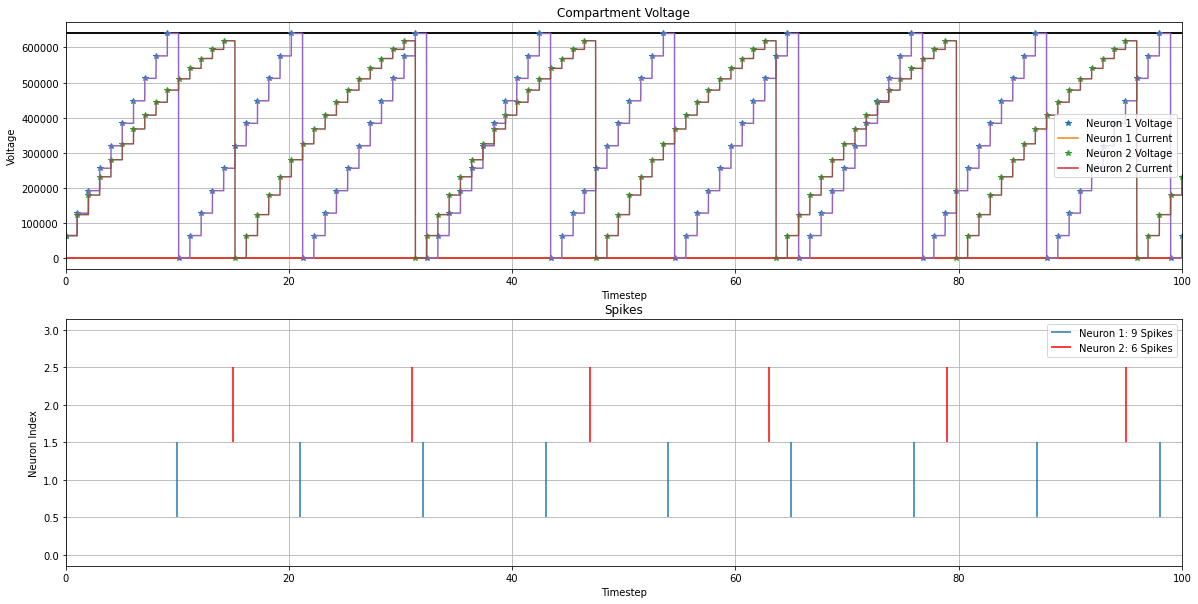

In [6]:
# plot logs
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, neuron_1.voltage_log, '*')
plt.plot(t, neuron_1.current_log)

plt.plot(t, neuron_2.voltage_log, '*')
plt.plot(t, neuron_2.current_log)

plt.plot(t2, f1(t2))
plt.plot(t2, f2(t2))
plt.hlines(neuron_1.computed_v_thresh, 0, num_timesteps)
plt.hlines(neuron_2.computed_v_thresh, 0, num_timesteps)

plt.xlabel('Timestep')
plt.ylabel('Voltage')
plt.grid()
plt.xlim(0, num_timesteps)
plt.title('Compartment Voltage')
plt.legend(['Neuron 1 Voltage', 'Neuron 1 Current',
            'Neuron 2 Voltage', 'Neuron 2 Current'])

plt.subplot(212)
neuron_1.plot_raster(lineoffsets=1)
neuron_2.plot_raster(lineoffsets=2, color='r')
plt.xlim(0, num_timesteps)
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.grid()
plt.title('Spikes')
plt.legend(['Neuron 1: {} Spikes'.format(neuron_1.num_spikes), 'Neuron 2: {} Spikes'.format(neuron_2.num_spikes)])